<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/color_adjustment_20230716.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls /gdrive/MyDrive/DATA/HuBMAP

annotation_info.csv    images_info.csv	      test
blue_images	       masks		      test2
coco_85train_dataset   masks_white_bkgrnd     test_list.csv
coco_85train_dataset2  norm_images	      tile_meta.csv
coco_85train_dataset3  polygons.jsonl	      train_list.csv
enhanced_images        red_images	      val_list.csv
gray_images	       Results		      wsi_meta.csv
images		       sample_submission.csv


In [5]:
# imports libraries
import glob
import os
import shutil
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import PIL
from PIL import Image, ImageOps
from PIL import ImageEnhance
from scipy.ndimage import label
from tqdm.notebook import tqdm_notebook

%matplotlib inline

In [13]:
pip show pillow

Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bokeh, dopamine-rl, fastai, imageio, imgaug, matplotlib, scikit-image, torchvision, wordcloud


<module 'PIL' from '/usr/local/lib/python3.10/dist-packages/PIL/__init__.py'>

In [ ]:
images_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/images_info.csv',index_col=0)
images_with_masks = images_info[images_info['has_mask']=='yes']
images_with_masks

id has_mask                                         image_path
3     da5cca9855f5      yes  /gdrive/MyDrive/DATA/HuBMAP/images/da5cca9855f...
6     db8391d91d8d      yes  /gdrive/MyDrive/DATA/HuBMAP/images/db8391d91d8...
10    daf9beac4413      yes  /gdrive/MyDrive/DATA/HuBMAP/images/daf9beac441...
12    da3180fa5201      yes  /gdrive/MyDrive/DATA/HuBMAP/images/da3180fa520...
14    dad151b200fe      yes  /gdrive/MyDrive/DATA/HuBMAP/images/dad151b200f...
...            ...      ...                                                ...
7019  00ca2f4c8918      yes  /gdrive/MyDrive/DATA/HuBMAP/images/00ca2f4c891...
7021  00656c6f2690      yes  /gdrive/MyDrive/DATA/HuBMAP/images/00656c6f269...
7022  00da8fdf2391      yes  /gdrive/MyDrive/DATA/HuBMAP/images/00da8fdf239...
7026  003504460b3a      yes  /gdrive/MyDrive/DATA/HuBMAP/images/003504460b3...
7031  00da70813521      yes  /gdrive/MyDrive/DATA/HuBMAP/images/00da7081352...

[1633 rows x 3 columns]

In [ ]:
def assign_class_color(mask_input,assign_color=False):
  print(mask_input.shape)


  # If mask is not a numpy (some sort tf eagortensor)
  # convert to numpy array - this is for pre-mask
  #if type(mask_input) is not np.ndarray:
  #  mask_input = np.squeeze(mask_input.numpy(),-1).astype(np.uint8)

  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  if assign_color:  # assign different color to all four classes
    palette = [255,255,255,     # 0=white
              255,0,0,          # 1= red
              255,255,0,        # 2=yellow
              0,0,255]          # 3=blue
  else: # assign color only to blood vessels and keep the rest white
    palette = [255,255,255,     # 0= white
              255,0,0,          # 1= red
              255,255,255,      # 2= white
              255,255,255]      # 3= white

  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(mask_input,'P')

  # Put the palette in
  mask_pi.putpalette(palette)

  return mask_pi


In [ ]:
def display(image_id,image_path,mask_path,image_mod):

  image = Image.open(image_path)

  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

  mask = assign_class_color(mask,assign_color=True)

  plt.figure(figsize=(10,10))

  plt.subplot(1,5,1)
  plt.imshow(image)
  plt.title(f'Original: {image_id}')
  plt.axis('off')

  plt.subplot(1,5,2)
  plt.imshow(mask)
  plt.title(f'Mask')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1,5,3)
  plt.imshow(image)
  plt.imshow(mask, alpha=0.4)
  plt.title(f'Overlay: Original + Mask')
  plt.axis('off')

  plt.subplot(1,5,4)
  plt.imshow(image_mod,cmap='Greys')
  plt.title(f'Modified Image')
  plt.axis('off')

  plt.subplot(1,5,5)
  plt.imshow(image_mod,cmap='Greys')
  plt.imshow(mask, alpha=0.4)
  plt.title(f'Overlay: Original + Mask')
  plt.axis('off')



  return image, image_mod

plt.show()



In [ ]:
def process_image(image_path):
  image = Image.open(image_path)
  image = ImageOps.grayscale(image)

  image_bright = ImageEnhance.Brightness(image)
  image = image_bright.enhance(1.1)

  image_enhance = ImageEnhance.Contrast(image)
  image = image_enhance.enhance(1.5)

  return image




(512, 512)


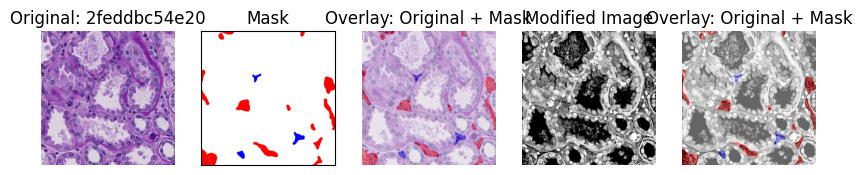

In [ ]:
np.random.seed(616)


mask_path_folder = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

row = images_with_masks.sample()

image_id = row['id'].values[0]
image_path = row['image_path' ].values[0]
mask_path = mask_path_folder + image_id + '_mask.tif'

image_mod = process_image(image_path)

image, image_mod = display(image_id,image_path,mask_path,image_mod)


In [ ]:
arr = np.asarray(image_mod)
arr.shape

(512, 512)

In [ ]:
np.unique(arr)


array([ 0,  1,  2,  4,  5,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23,
       25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 41, 43, 44, 46, 47, 49,
       50, 52, 53, 55, 56, 58, 59], dtype=uint8)

In [ ]:
!ls /gdrive/MyDrive/DATA/HuBMAP


annotation_info.csv    masks		      test2
blue_images	       masks_white_bkgrnd     test_list.csv
coco_85train_dataset   norm_images	      tile_meta.csv
coco_85train_dataset2  polygons.jsonl	      train_list.csv
enhanced_images        red_images	      val_list.csv
gray_images	       Results		      wsi_meta.csv
images		       sample_submission.csv
images_info.csv        test


In [ ]:
#!mkdir /gdrive/MyDrive/DATA/HuBMAP/gray_images

In [ ]:
path_dir = '/gdrive/MyDrive/DATA/HuBMAP/gray_images/'

In [ ]:

for path in tqdm_notebook(images_with_masks['image_path'],total=len(images_with_masks)):

  image_id = path.split('/')[-1].split('.')[0]
  image = process_image(path)

  image.save(path_dir + image_id + '.tif')



  0%|          | 0/1633 [00:00<?, ?it/s]

In [ ]:
image_id = images_with_masks['id'].sample().values[0]

new_path = '/gdrive/MyDrive/DATA/HuBMAP/gray_images/'

image = cv2.imread(new_path + image_id + '.tif',cv2.IMREAD_GRAYSCALE)
image_copy = Image.open(new_path + image_id + '.tif')

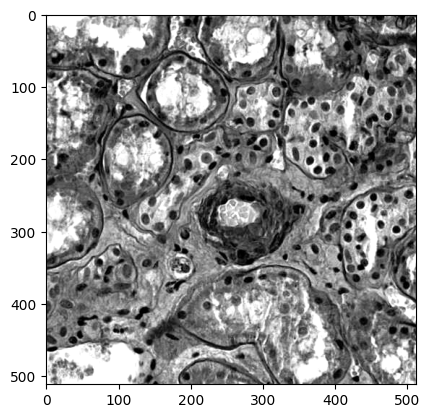

In [ ]:
plt.imshow(image,cmap='gray')
plt.show()

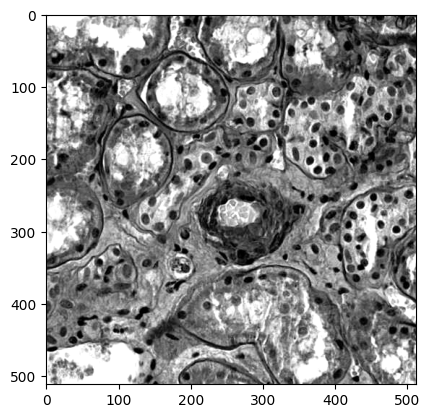

In [ ]:
plt.imshow(image_copy,cmap='gray')
plt.show()

In [ ]:
images_with_masks.loc[images_with_masks['id'] == image_id,]

id has_mask                                         image_path
2003  92450a58e849      yes  /gdrive/MyDrive/DATA/HuBMAP/images/92450a58e84...

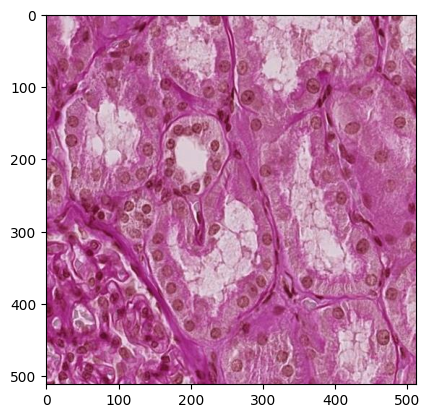

TypeError: ignored

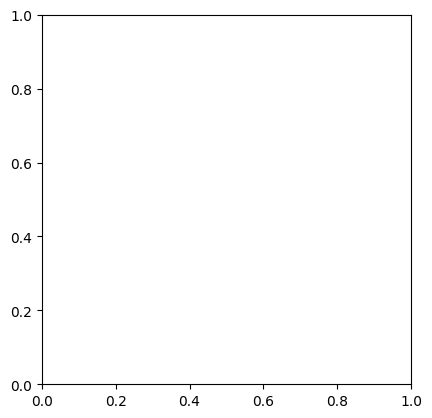

In [ ]:
original = '/gdrive/MyDrive/DATA/HuBMAP/images/dad151b200fe.tif'
rgb = '/gdrive/MyDrive/DATA/HuBMAP/rgb_images/dad151b200fe.tif'

image = cv2.imread(original)
rgb = cv2.imread(rgb)

plt.imshow(image)
plt.show()

plt.imshow(rgb)
plt.show()


In [ ]:

image_path = '/gdrive/MyDrive/DATA/HuBMAP/images/'
identifier = 'dad151b200fe'
dst_path = os.path.join('/content/images/',identifier)

#os.makedirs(dst_path,exist_ok=True)


shutil.copyfile(os.path.join(image_path, f"{identifier}.tif"),
            dst_path)

FileNotFoundError: ignored

In [ ]:
sample = images_with_masks.sample()
image_path = sample['image_path'].values[0]



In [ ]:
image_1 = cv2.imread(image_path)
image_2 = cv2.imread(image_path)

if np.array_equal(image_1,image_2):
  print('The images are the same')
else:
  print('The images are different')

The images are the same


In [ ]:
image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

if np.array_equal(image_1,image_2_rgb):
  print('The images are the same')
else:
  print('The images are different')


The images are different


In [ ]:
image_cv2 = cv2.imread(image_path)
image_cv2_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

image_pil = Image.open(image_path)

if np.array_equal(image_cv2_rgb,image_pil):
  print('The images are the same')
else:
  print('The images are different')




The images are the same


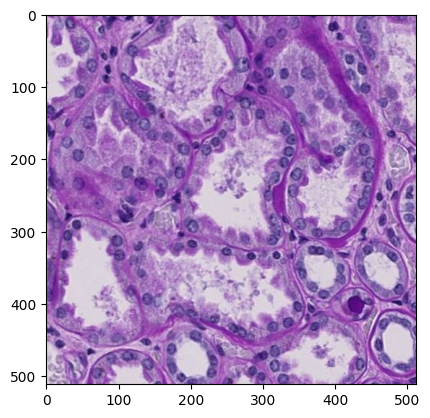

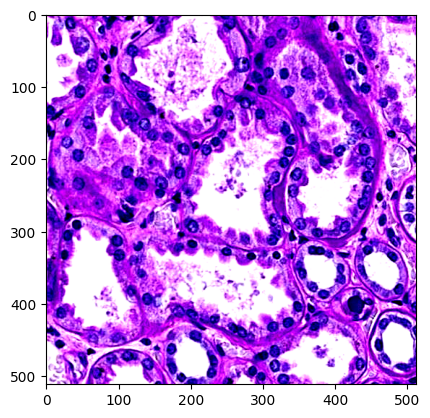

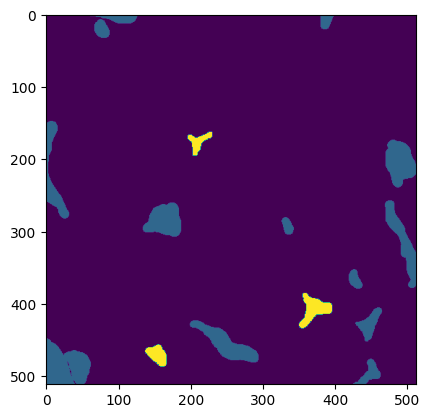

In [ ]:
image_id = image_path.split('/')[-1].split('.')[0]

image = Image.open(image_path)

#image.save(f'/content/images/{image_id}.tif')

mod_image = process_image(image_path)

mask_path = mask_path_folder + image_id + '_mask.tif'

mask = Image.open(mask_path)



plt.imshow(image)
plt.show()
plt.imshow(mod_image)
plt.show()
plt.imshow(mask)
plt.show()




In [ ]:
image.save(f'/content/images/{image_id}.tif')

mod_image.save(f'/content/images/{image_id}_mod.tif')



In [ ]:
!ls /content/images/


2feddbc54e20_mod.tif  2feddbc54e20.tif


In [ ]:
img1 = cv2.imread('/content/images/'+ image_id + '.tif')
img2 = cv2.imread('/content/images/' + image_id + '_mod.tif')

if np.array_equal(img1,img2):
  print('The images are the same')
else:
  print('The images are different')


The images are different


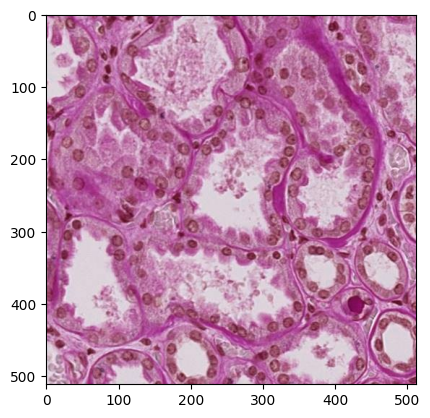

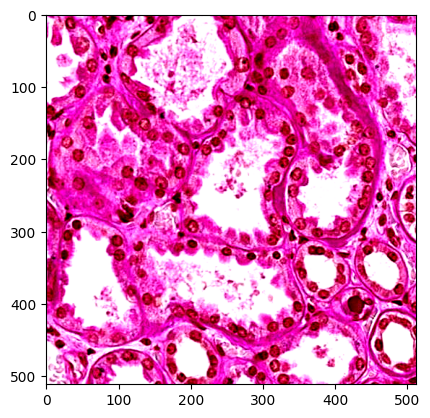

In [ ]:
plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

In [ ]:
img3 = Image.open('/content/images/'+ image_id + '.tif')
img4 = Image.open('/content/images/' + image_id + '_mod.tif')

if np.array_equal(img3,img4):
  print('The images are the same')
else:
  print('The images are different')



The images are different


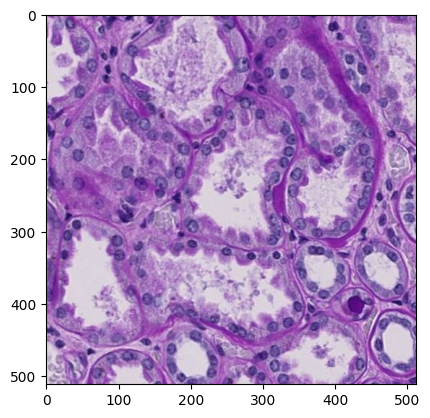

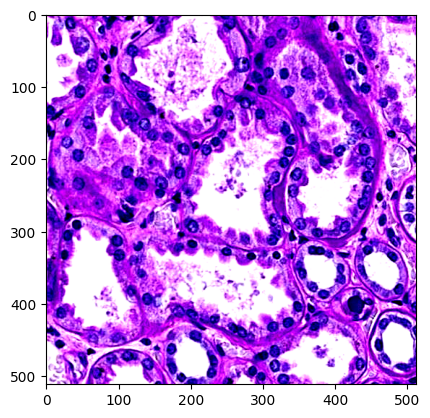

In [ ]:
plt.imshow(img3)
plt.show()

plt.imshow(img4)
plt.show()


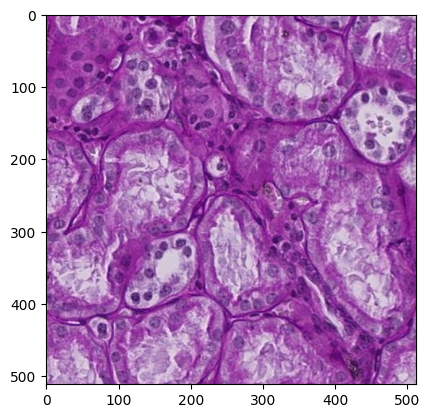

In [ ]:
image_path = images_with_masks.sample()['image_path'].values[0]

image_id = image_path.split('/')[-1].split('.')[0]

image = Image.open(image_path)
plt.imshow(image)
plt.show()



In [ ]:
img_arr = np.array(image)

print(img_arr.shape)
print(img_arr.dtype)
print(type(img_arr))





(512, 512, 3)
uint8
<class 'numpy.ndarray'>


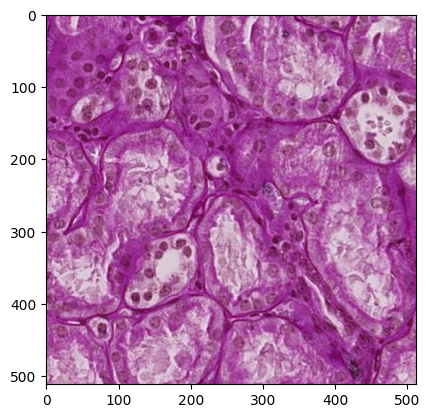

In [ ]:
image_2 = cv2.imread(image_path)

plt.imshow(image_2)
plt.show()




In [ ]:


print(image_2.shape)
print(image_2.dtype)
print(type(image_2))


(512, 512, 3)
uint8
<class 'numpy.ndarray'>


In [ ]:
img_arr == image_2

array([[[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        ...,
        [ True,  True,  True],
        [False,  True, False],
        [False,  True, False]],

       [[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        ...,
        [False,  True, False],
        [False,  True, False],
        [False,  True, False]],

       [[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        ...,
        [False,  True, False],
        [False,  True, False],
        [False,  True, False]],

       ...,

       [[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        ...,
        [False,  True, False],
        [False,  True, False],
        [False,  True, False]],

       [[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        ...,
        [False,  True, False],
        [False,  True, False],
        [False,

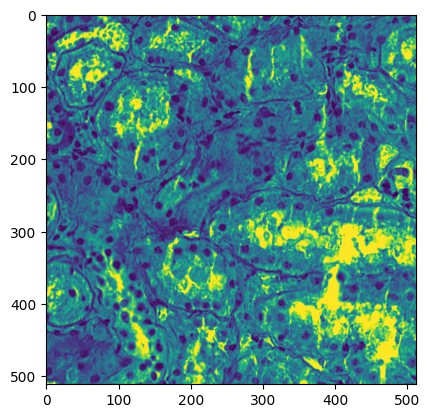

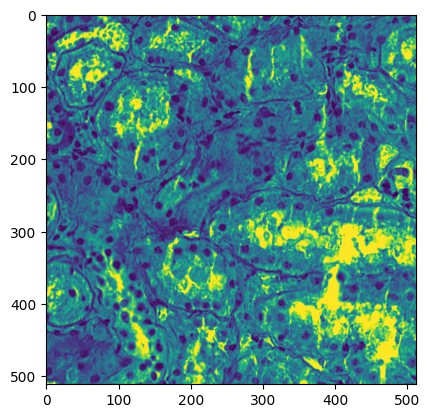

array([512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 51

In [ ]:
img = Image.open('/content/test/da3180fa5201.tif')
plt.imshow(img)
plt.show()

img_b = cv2.imread('/content/test/da3180fa5201.tif',cv2.IMREAD_GRAYSCALE)
plt.imshow(img_b)
plt.show()

img_arr = np.asarray(img)

sum(img_arr == img_b)

In [ ]:
#!ls /gdrive/MyDrive/DATA/HuBMAP/masks/

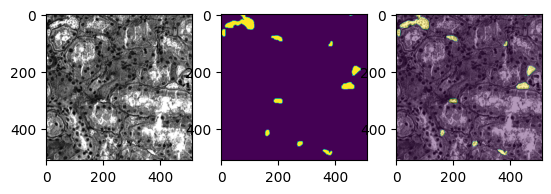

In [ ]:
img2 = cv2.imread('/content/test/da3180fa5201.tif')
#img2_mask = cv2.imread('/gdrive/MyDrive/DATA/HuBMAP/masks/da3180fa5201_mask.tif')
img2_mask = cv2.imread('/gdrive/MyDrive/DATA/HuBMAP/masks/da3180fa5201_mask.tif',cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img2)


plt.subplot(1,3,2)
plt.imshow(img2_mask)

plt.subplot(1,3,3)
plt.imshow(img2)
plt.imshow(img2_mask,alpha=0.4)

plt.show()








In [ ]:
print(img2_mask)

None


In [ ]:
#!ls /gdrive/MyDrive/DATA/HuBMAP/


annotation_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_info.csv',index_col=0)

annotation_inf0.loc['da3180fa5201',]










blood_vessel    11
glomerulus       0
unsure           0
Name: da3180fa5201, dtype: int64

In [ ]:
img_arr = np.array(img)

img_arr == img2







<ipython-input-19-4f326b183880>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  img_arr == img2


False